In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np 
from myutils import Helpers as h
from myutils import Complexity_Measures as cm
from sklearn.decomposition import PCA
from myutils import Datasets as ds

#Magic Command, so changes in myutils module are reloaded
%load_ext autoreload
%autoreload 1
%aimport myutils


# Explore Data
- random: generates random pixels with random label , expected to have the greatest complextity
- all_numbers: contains all numbers, expected to have lower complextiy than random
- six_and_nines: only take 6 and 9s , expected to have lower complexity tahn all numbers
- only_sixes: only take 6es, execpted to have lowest complexity

In [5]:
all_numbers, six_and_nines, only_sixes, random = ds.get_all_data()


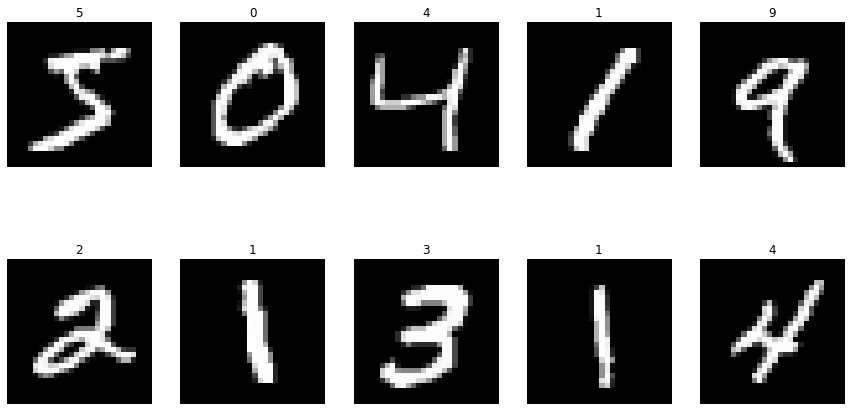

In [7]:
rows = 2
cols = 5

h.plot_grid(rows=2,cols=5,data=all_numbers[0],labels=all_numbers[1])

# Test classification to be performed only with the result of the PCA.

On the test plot you can see that it seems that the 6s and 9s always look about the same. For the classification the simplest possibility was used: if the pixel in the upper left corner is white -> 6 otherwise 9. This gives a surprisingly good accuracy of 82%.

-> thus the assumption that the variational_circuit does not "perform" so much or has to solve an already simple problem.

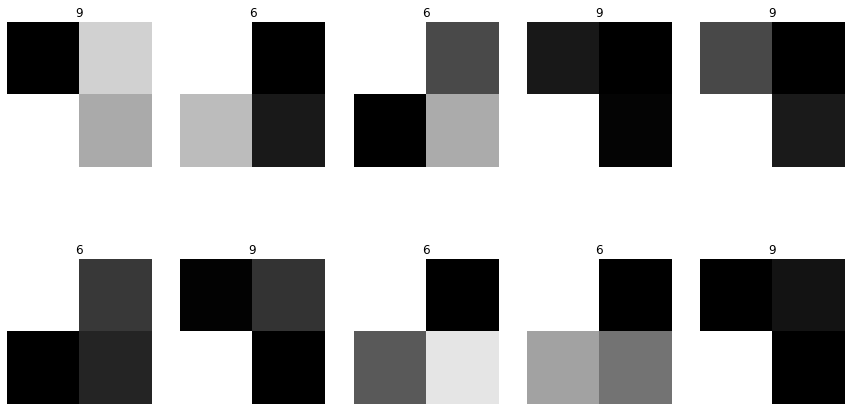

In [8]:
six_nine_pca = h.PCA(six_and_nines[0], n_components=4)

h.plot_grid(six_nine_pca,labels=six_and_nines[1])


Normalize values between 0 and 255, because PCA moves value range

In [9]:
six_nine_pca_normalized = h.normalize(six_nine_pca)

In [10]:
predictions = list()
for i in range(len(six_nine_pca)):
    if six_nine_pca_normalized[i][0][0] > 150:
        predictions.append(6)
    else:
        predictions.append(9)

Accurracy 0.8198365214460268


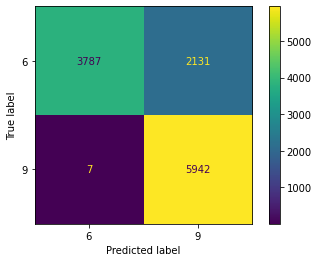

In [12]:
h.plot_classify_results(predictions=predictions,labels=six_and_nines[1])

Structure of PCA results are a little bit dissapointing, i would have hoped that PCA result look more alike, since the starting images are pretty similar

**=> a hint that PCA is maybe not the best method for downscaling the images**

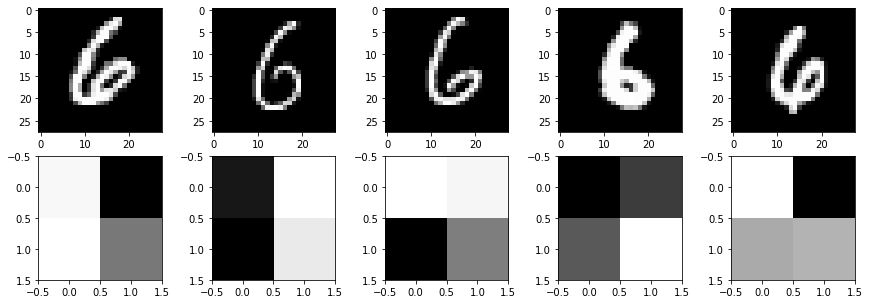

In [13]:
only_6_pca = h.PCA(only_sixes[0], n_components=4)

_, ax = plt.subplots(2,5,figsize=(15,5))
i=0
for index in range(5): 
    ax[0,i].imshow(only_sixes[0][index],cmap="gray")
    ax[1,i].imshow(only_6_pca[index],cmap="gray")
    i+=1

# Entropy Measure
For each created dataset, take 4000 random samples (since dataset sizes are not equal -> all numbers > six&nines > only sixes). Calculate the entropy like proposed in paper below.
  
Like expected the random dataset gets the largest entropy. But the other dataset aren't to different from each other, which ist not what our hope was (Because the dataset with all numbers is cleary more "complex" than the dataset with only sixes). Especially the six&nine dataset is only slightly higher entropy than only sixes.
  
Also the entropy for all pixels get plotet.



*Rahane, A. A., & Subramanian, A. (2020). Measures of Complexity for Large Scale Image Datasets. 2020 International Conference on Artificial Intelligence in Information and Communication (ICAIIC), 282–287. https://doi.org/10.1109/ICAIIC48513.2020.9065274*

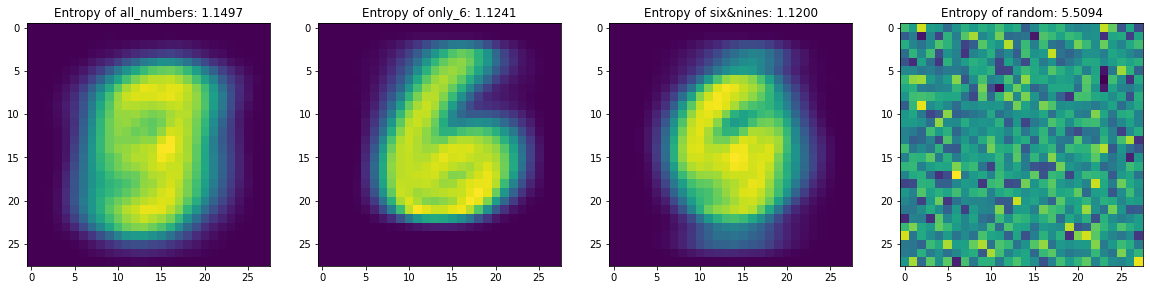

In [14]:
datasets = {
    "all_numbers": all_numbers[0],
    "only_6": only_sixes[0],
    "six&nines": six_and_nines[0],
    "random": random[0]
}

fig, ax = plt.subplots(1,4,figsize=(20,10))
i = 0

for dataset in datasets:
    d_set = datasets[dataset]
    np.random.shuffle(d_set)
    np.random.seed(1337)
    d_set = d_set[:4000]

    entropy = cm.entropy(d_set)

    ax[i].set_title("Entropy of {}: {:.4f}".format(dataset, entropy.mean()))
    
    ax[i].imshow(entropy.reshape(d_set.shape[1], d_set.shape[2]),cmap="viridis")
    i+=1

plt.show()

    


You can see that all 3 datasets have about the same entropy after applying PCA. This means either PCA is unsuitable or entropy. For further comments or mistakes I made, I would be grateful at this point :) 

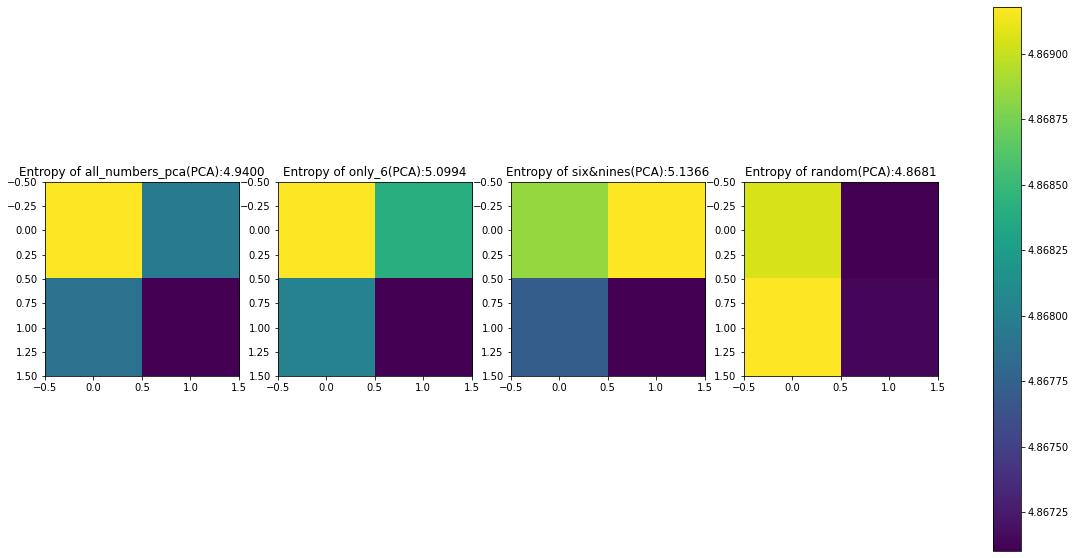

In [15]:
all_numbers_pca = h.PCA(all_numbers[0], n_components=4)
random_pca = h.PCA(random[0], n_components=4)
six_nine_pca = h.PCA(six_and_nines[0], n_components=4)
only_6_pca = h.PCA(only_sixes[0], n_components=4)

datasets = {
    "all_numbers_pca": all_numbers_pca,
    "only_6": only_6_pca,
    "six&nines": six_nine_pca,
    "random": random_pca
}

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
i = 0

for dataset in datasets:
    d_set = datasets[dataset]
    np.random.shuffle(d_set)
    np.random.seed(1337)
    d_set = d_set[:4000]
    # the data is normalized in the range 0-255
    d_set = h.normalize(d_set)
    entropy_pca = cm.entropy(d_set)
    ax[i].set_title("Entropy of {}(PCA):{:.4f}".format(dataset, entropy_pca.mean()))

    im = ax[i].imshow(entropy_pca.reshape(2,2))
    i += 1
fig.colorbar(im, ax=ax)
plt.show()
